# Developing the Population Health Model

## Overview 

This notebook contains the code to develop the population health model. 

Initially 3 different models are compared (Linear regression, Random Forest regresstion, Gradient Boosted regression).

Hyper-parameters of the best model are fine-tuned to maximise performance in unseen data while preventing over-fitting and minimising model complexity

In [1]:
#turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings('ignore')

## Import libraries 

In [2]:
import os
import pandas as pd
import numpy as np
import pickle as pkl

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold


import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## Import data 

In [3]:
dta = pd.read_csv('https://raw.githubusercontent.com/CharlotteJames/ed-forecast/main/data/master_scaled_new.csv',
                  index_col=0)

In [4]:
dta.columns = ['_'.join([c.split('/')[0],c.split('/')[-1]]) 
               if '/' in c else c for c in dta.columns]

In [5]:
dta.shape

(1618, 13)

### Add random feature

In [6]:
# Adding random features

rng = np.random.RandomState(0)
rand_var = rng.rand(dta.shape[0])
dta['rand1'] = rand_var

In [7]:
dta.shape

(1618, 14)

### Function to aggregate data  

In [8]:
def group_data(data, features):

    #ensure no identical points in train and test

    grouped = pd.DataFrame()
    
    for pop, group in data.groupby('population'):

        #if len(group.lives.unique())>1:

        #    print('multiple CCG with same population')

        ccg_year = pd.Series(dtype='float64')

        for f in features:

            ccg_year[f] = group[f].unique()[0]

        ccg_year['ae_attendances_attendances'] \
        = group.ae_attendances_attendances.mean()
        

        grouped = grouped.append(ccg_year, ignore_index=True)
        
    return grouped

## Model Comparison

Features in the dataset that measure population and population health are:

- *population*: 
- *People*: 
- *Places*: 
- *Lives*: 

### Pair plot 

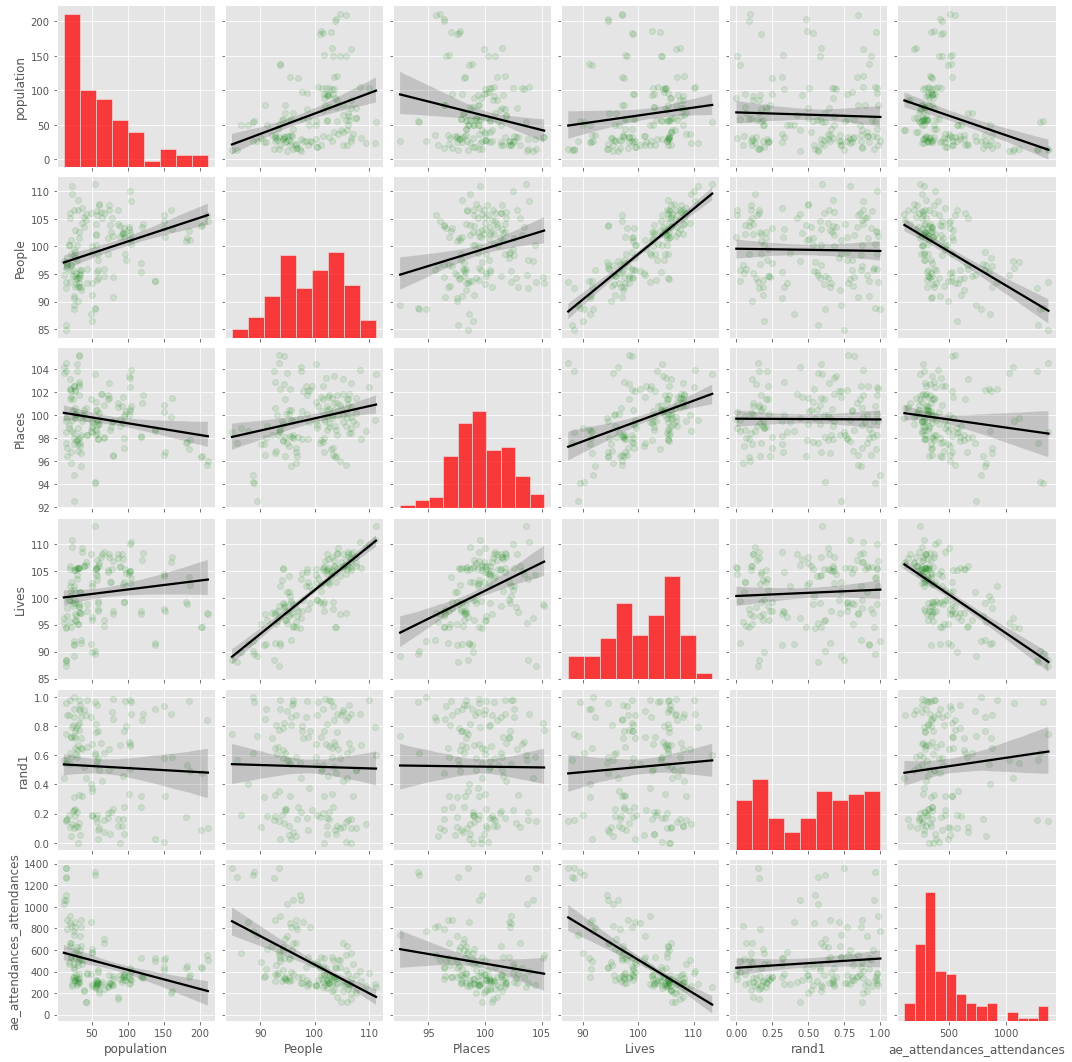

In [9]:
features = ['population',
            'People', 'Places',
            'Lives', 'rand1']

grouped = group_data(dta, features)

fig = sns.pairplot(grouped.select_dtypes(include=np.number),
                   kind="reg",
                   plot_kws={'line_kws':{'color':'black'}, 
                            'scatter_kws': 
                             {'color':'green','alpha': 0.1}},
                   diag_kws={'color':'red'})

### Linear Regression 

In [10]:
model = LinearRegression()

features = ['population',
            'People', 'Places',
            'Lives', 'rand1']

grouped = group_data(dta, features)
    
y = grouped['ae_attendances_attendances']
X = grouped[features]

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    
scores_train, scores_test, feats = [],[],[]
    
for train_index, test_index in cv.split(X, y):
        
    model.fit(X.iloc[train_index], y.iloc[train_index])
        
    scores_test.append(model.score(X.iloc[test_index],
                                   y.iloc[test_index]))
    scores_train.append(model.score(X.iloc[train_index], 
                                    y.iloc[train_index]))

    feats.append(model.coef_)

#### Performance 

In [11]:
results=pd.DataFrame()
results['train'] = scores_train
results['test'] = scores_test

In [12]:
results.describe()

,train,test
count,25.000000,25.000000
mean,0.540455,0.379096
std,0.033633,0.336233
min,0.474597,-0.964399
25%,0.520654,0.368519
50%,0.543342,0.478593
75%,0.565362,0.558210
max,0.601924,0.630244


#### Feature Importance 

In [13]:
feat_imp = pd.DataFrame()

for i,f in enumerate(features):
    
    feat_imp[f] = np.array(feats)[:,i]

feat_imp.describe()

,population,People,Places,Lives,rand1
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,-1.298377,7.514601,11.947955,-38.263529,125.767990
std,0.158027,2.832702,5.822763,3.586429,28.831477
min,-1.639090,3.472580,-0.201465,-45.824552,84.869775
25%,-1.388330,5.350478,7.071549,-40.089392,105.625003
50%,-1.307197,6.589994,12.961259,-38.358653,125.179046
75%,-1.218501,8.881782,16.760270,-36.936270,142.261655
max,-0.870452,14.246297,20.242753,-30.461520,197.732420


### Random Forest 

In [14]:
model = RandomForestRegressor(max_depth=4, n_estimators=2, 
                              random_state=0)

y = grouped['ae_attendances_attendances']

X = grouped[features]

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    
scores_train, scores_test, feats = [],[],[]
    
for train_index, test_index in cv.split(X, y):
        
    model.fit(X.iloc[train_index], y.iloc[train_index])
        
    scores_test.append(model.score(X.iloc[test_index],
                                   y.iloc[test_index]))
    scores_train.append(model.score(X.iloc[train_index],
                                    y.iloc[train_index]))
    
    feats.append(model.feature_importances_)

#### Performance 

In [15]:
results=pd.DataFrame()
results['train'] = scores_train
results['test'] = scores_test

In [16]:
results.describe()

,train,test
count,25.000000,25.000000
mean,0.797940,0.530299
std,0.045837,0.336113
min,0.714406,-0.851795
25%,0.767688,0.549337
50%,0.805949,0.598507
75%,0.820594,0.683305
max,0.876322,0.826358


#### Feature Importance 

In [17]:
feat_imp = pd.DataFrame()

for i,f in enumerate(features):
    
    feat_imp[f] = np.array(feats)[:,i]

feat_imp.describe()

,population,People,Places,Lives,rand1
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.456247,0.084433,0.077484,0.355720,0.026116
std,0.173910,0.094269,0.050263,0.190689,0.021850
min,0.146310,0.005961,0.010178,0.034775,0.000000
25%,0.346103,0.028695,0.044565,0.222511,0.006183
50%,0.438064,0.048710,0.068142,0.379977,0.023562
75%,0.586481,0.106833,0.094927,0.440977,0.048037
max,0.771119,0.328866,0.228716,0.765357,0.072325


### Gradient boosted tress

In [18]:
model = GradientBoostingRegressor(max_depth=5, n_estimators=5,
                                  random_state=1)

y = grouped['ae_attendances_attendances']

X = grouped[features]

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    
scores_train, scores_test, feats = [],[],[]
    
for train_index, test_index in cv.split(X, y):
        
    model.fit(X.iloc[train_index], y.iloc[train_index])
        
    scores_test.append(model.score(X.iloc[test_index],
                                   y.iloc[test_index]))
    scores_train.append(model.score(X.iloc[train_index],
                                    y.iloc[train_index]))
    
    feats.append(model.feature_importances_)

#### Performance 

In [19]:
results=pd.DataFrame()
results['train'] = scores_train
results['test'] = scores_test

In [20]:
results.describe()

,train,test
count,25.000000,25.000000
mean,0.591351,0.375395
std,0.014649,0.170331
min,0.556442,-0.247993
25%,0.583247,0.301704
50%,0.590246,0.433064
75%,0.601433,0.487964
max,0.618456,0.539789


#### Feature Importance 

In [21]:
feat_imp = pd.DataFrame()

for i,f in enumerate(features):
    
    feat_imp[f] = np.array(feats)[:,i]

feat_imp.describe()

,population,People,Places,Lives,rand1
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.459397,0.078644,0.105263,0.331099,0.025597
std,0.186142,0.051783,0.075318,0.232194,0.015847
min,0.172220,0.013081,0.002342,0.031901,0.003054
25%,0.299999,0.049349,0.041884,0.144045,0.010623
50%,0.531181,0.060140,0.096542,0.210499,0.026689
75%,0.601243,0.087788,0.138557,0.513216,0.037837
max,0.703193,0.213845,0.263458,0.715445,0.054122


### Summary 

**Logistic Regression**

- Variable performance with different splits: mean $R^2$ = 0.4, minimum $R^2$ = -0.5 in test set

**Random Forest**

- Best performance with mean $R^2$ = 0.5 in test data. 
- Performance also variable: minimum $R^2$ = -0.8
- Feature importance is stable: population is most important, followed by Lives, People then Places. 
- The random feature has low importnace which validates the importance of other features.

**Gradient Boosted Trees**

- Doesn't perform as well as a Random Forest, mean $R^2$ = 0.4 in test data
- Performance also variable: minimum $R^2$ = -0.24
- Feature importance is not agreement with the Random Forest, with Places more important than People.



## Hyper parameter tuning 

The best model is the Random Forest. To ensure the model is not over fit to the training data we compare performance when the following parameters are varied:

- max_depth: the maximum size of any tree 
- n_estimators: the number of trees in the forest

### Maximum Depth 

In [22]:
d = [1,2,3,4,5,6,7]

res_train,res_test = [],[]

for depth in d:
    
    model = RandomForestRegressor(max_depth=depth, 
                                  n_estimators=3, random_state=0)

    y = grouped['ae_attendances_attendances']

    X = grouped[features]

    cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)

    scores_train, scores_test = [],[]

    for train_index, test_index in cv.split(X, y):

        model.fit(X.iloc[train_index], y.iloc[train_index])

        scores_test.append(model.score(X.iloc[test_index],
                                       y.iloc[test_index]))
        scores_train.append(model.score(X.iloc[train_index]
                                        , y.iloc[train_index]))
        
    res_train.append(scores_train)
    res_test.append(scores_test)

#### Plot 

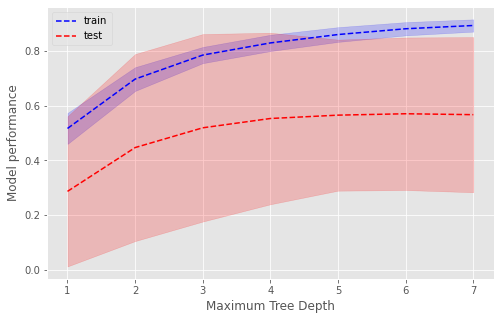

In [23]:
fig,ax = plt.subplots(figsize=(8,5))

plt.plot(d, np.mean(res_train, axis=1), 'b--', label='train')
plt.plot(d, np.mean(res_test, axis=1), 'r--', label='test')

plt.fill_between(d, y1=(np.mean(res_train, axis=1)-np.std(res_train, axis=1)),
                 y2=(np.mean(res_train, axis=1)+np.std(res_train, axis=1)),
                 color='b', alpha=0.2)

plt.fill_between(d, y1=(np.mean(res_test, axis=1)-np.std(res_test, axis=1)),
                 y2=(np.mean(res_test, axis=1)+np.std(res_test, axis=1)), 
                 color='r', alpha=0.2)

plt.legend(loc='best')
plt.xlabel('Maximum Tree Depth')
plt.ylabel('Model performance')

plt.show()

A depth of 5 is optimal. After this, there is no improvement in performance on unseen data (test, red dashed line) and performance continues to increase in the training data (blue dashed line) suggesting overfitting.

### Number of Trees

In [24]:
n = [1,2,3,4,5,6,7]

res_train,res_test = [],[]

for est in n:
    
    model = RandomForestRegressor(max_depth=4, n_estimators=est,
                                  random_state=0)

    y = grouped['ae_attendances_attendances']

    X = grouped[features]

    cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)

    scores_train, scores_test = [],[]

    for train_index, test_index in cv.split(X, y):

        model.fit(X.iloc[train_index], y.iloc[train_index])

        scores_test.append(model.score(X.iloc[test_index],
                                       y.iloc[test_index]))
        scores_train.append(model.score(X.iloc[train_index],
                                        y.iloc[train_index]))
        
    res_train.append(scores_train)
    res_test.append(scores_test)

#### Plot 

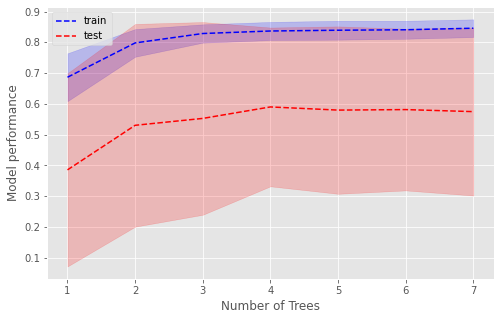

In [25]:
fig,ax = plt.subplots(figsize=(8,5))

plt.plot(d, np.mean(res_train, axis=1), 'b--', label='train')
plt.plot(d, np.mean(res_test, axis=1), 'r--', label='test')

plt.fill_between(d, y1=(np.mean(res_train, axis=1)-np.std(res_train, axis=1)),
                 y2=(np.mean(res_train, axis=1)+np.std(res_train, axis=1)),
                 color='b', alpha=0.2)

plt.fill_between(d, y1=(np.mean(res_test, axis=1)-np.std(res_test, axis=1)),
                 y2=(np.mean(res_test, axis=1)+np.std(res_test, axis=1)),
                 color='r', alpha=0.2)

plt.legend(loc='best')
plt.xlabel('Number of Trees')
plt.ylabel('Model performance')

plt.show()

The optimal number of trees is 4, beyond which there is no improvement in the training or test set.

## Final Model for paper

Fit the Random forest with optimal parameters

In [26]:
model = RandomForestRegressor(max_depth=5, n_estimators=4,
                              random_state=0)

y = grouped['ae_attendances_attendances']

X = grouped[features]

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    
scores_train, scores_test, feat = [],[],[]
    
for train_index, test_index in cv.split(X, y):
        
    model.fit(X.iloc[train_index], y.iloc[train_index])
        
    scores_test.append(model.score(X.iloc[test_index],
                                   y.iloc[test_index]))
    scores_train.append(model.score(X.iloc[train_index],
                                    y.iloc[train_index]))
    
    feat.append(model.feature_importances_)

### Performance 

In [27]:
results=pd.DataFrame()
results['train'] = scores_train
results['test'] = scores_test

In [28]:
results.describe()

,train,test
count,25.000000,25.000000
mean,0.871501,0.606538
std,0.027254,0.246910
min,0.801660,-0.071323
25%,0.857325,0.615846
50%,0.873249,0.683348
75%,0.895287,0.725724
max,0.913705,0.858876


### Feature Importance

In [29]:
feat_imp = pd.DataFrame()

for i,f in enumerate(features):
    
    feat_imp[f] = np.array(feats)[:,i]

feat_imp.describe()

,population,People,Places,Lives,rand1
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.459397,0.078644,0.105263,0.331099,0.025597
std,0.186142,0.051783,0.075318,0.232194,0.015847
min,0.172220,0.013081,0.002342,0.031901,0.003054
25%,0.299999,0.049349,0.041884,0.144045,0.010623
50%,0.531181,0.060140,0.096542,0.210499,0.026689
75%,0.601243,0.087788,0.138557,0.513216,0.037837
max,0.703193,0.213845,0.263458,0.715445,0.054122
